# Import packages

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
import numpy as np
import scipy.optimize as opt

# Inputs

In [69]:
data_file = "Data/Trapped Particle 01 - 2M pts.CSV"
nperseg = 2**15 # Used for scipy.signal.welch PSD calculation
r = 23 # pixels
T = 297 # Kelvin
eta = 0.00089 # Viscosity of water (dependent on temperature)
pix_to_dist = 374.14 # px per div (10 microns)

# Load and plot data

,TIME,CH1
0,-32.00000,-16.0
1,-31.99997,-16.2
2,-31.99994,-16.3
3,-31.99990,-16.5
4,-31.99987,-16.7
...,...,...
1999995,31.99984,-15.6
1999996,31.99987,-15.7
1999997,31.99990,-15.6
1999998,31.99994,-15.6


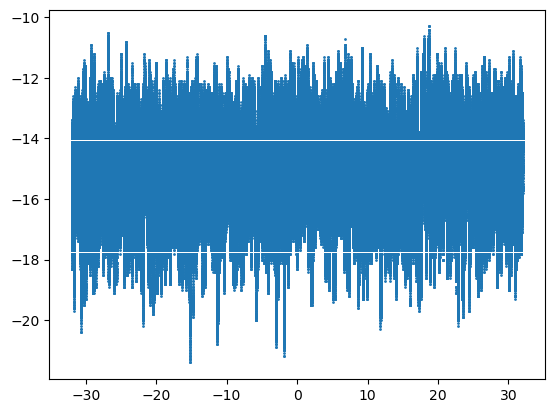

In [70]:
data = pd.read_csv(data_file, skiprows=15)
display(data)

plt.plot(data['TIME'], data['CH1'], 'o', markersize=1)
plt.show()

# Calculating FFT and PSD

In [71]:
voltages = data['CH1'] # Extract the signal
voltages = voltages - voltages.mean() # De-mean the signal

dt = data['TIME'].iloc[1] - data['TIME'].iloc[0] # Get the time step between points
total_timesteps = len(voltages) # Get the total number of time steps

# Compute PSD using scipy.signal.welch for better performance
welch = signal.welch(voltages, fs=1/dt, nperseg=nperseg, scaling='density')
freqs = welch[0]
psd = welch[1]

psds = pd.DataFrame({'Frequency': freqs, 'PSD': psd})

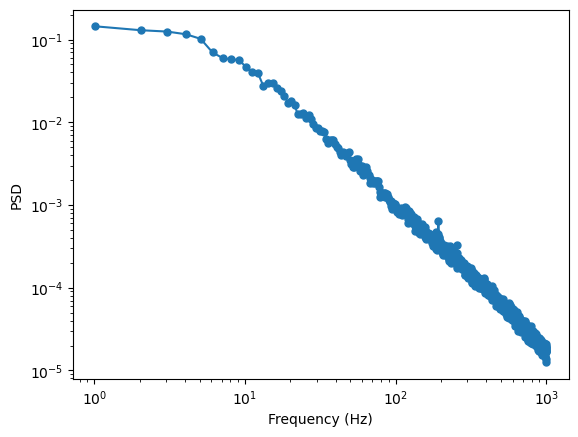

In [72]:
mask = psds['Frequency'] > 0 # Ignore the zero frequency
mask &= psds['Frequency'] < 1000 # Ignore high frequency noise

# We use a scatter plot with a connecting line
plt.plot(psds['Frequency'][mask], psds['PSD'][mask] , 'o-', markersize=5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.xscale('log')
plt.yscale('log')

# Least mean square fitting for PSD

Optimal Gamma: 45.653012732226884
Optimal f0: -0.8865142059037067
Optimal x2: 0.5671537633196406


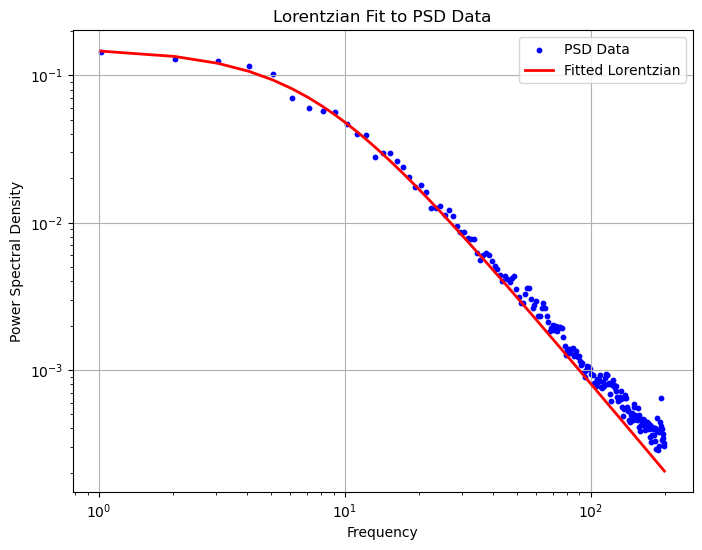

In [73]:
x_squared_expectation = np.mean((data['CH1'] - data['CH1'].mean())**2)

mask = psds['Frequency'] > 0 # Ignore the zero frequency
mask &= psds['Frequency'] < 200 # Ignore high frequency noise

# Define the Lorentzian function with f0 and gamma as parameters
def lorentzian(f, gamma, f0, x2):
    return (2 * x2 * (gamma / (2 * np.pi))) / ((f - f0)**2 + (gamma / (2 * np.pi))**2)

# Initial guesses for Gamma and f0
initial_guess = [30.0, -10.0, x_squared_expectation]  # [gamma, f0]

# Fit the Lorentzian function to PSD data
popt, _ = opt.curve_fit(
    lambda f, gamma, f0, x2: lorentzian(f, gamma, f0, x2),
    freqs[mask],
    psd[mask],
    p0=initial_guess
)

# Extract optimal parameters
gamma_opt, f0_opt, x2_opt = popt
print(f"Optimal Gamma: {gamma_opt}")
print(f"Optimal f0: {f0_opt}")
print(f"Optimal x2: {x2_opt}")

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(freqs[mask], psd[mask], label="PSD Data", color="blue", s=10)
plt.plot(freqs[mask], lorentzian(freqs[mask], gamma_opt, f0_opt, x2_opt), label="Fitted Lorentzian", color="red", lw=2)
plt.title("Lorentzian Fit to PSD Data")
plt.xlabel("Frequency")
plt.ylabel("Power Spectral Density")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

# Calculate rho

In [74]:
kb = 1.380649e-23 # SI units
r = r / pix_to_dist * 1e-5 # Convert radius to meters
zeta = 6 * np.pi * eta * r # Mobility
rho_vals = np.sqrt(psd * freqs**2 * np.pi**2 * zeta/(kb * T))

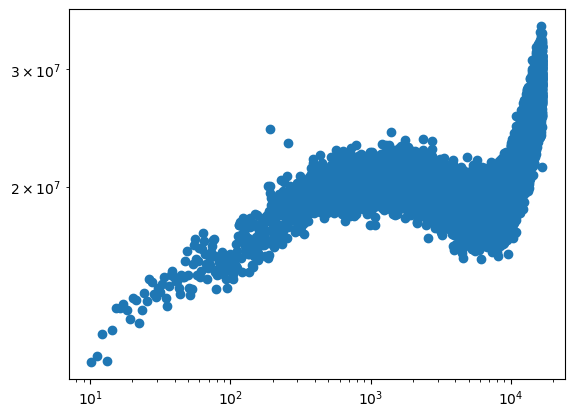

In [75]:
mask = freqs > 10
plt.scatter(freqs[mask], rho_vals[mask])
plt.xscale('log')
plt.yscale('log')

# Pick rho

In [76]:
rho = 2e7 # Select a rho value

# Calculate diffusion constant

In [77]:
data['x'] = data['CH1'] / rho
data['x'] = data['x'] - data['x'].mean() # Center the data
x_squared_expectation = (data['x']**2).mean() # Meters squared

kb = 1.380649e-23 # SI units
k = kb * T / x_squared_expectation # Spring constant
zeta = 6 * np.pi * eta * r # Mobility
gamma = k / zeta # Characteristic relaxation rate
D = gamma * x_squared_expectation # Diffusion coefficient
print("Diffusion coefficient: ", np.round(D, 17))

Diffusion coefficient:  3.9761e-13
